In [2]:
from __future__ import print_function, division
import numpy as np
import sys
sys.path.append('../src')
sys.path.append('../script')
sys.path.append('..')

import time
import torch
import pickle
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
from torch.nn import Parameter
from data_classes import RNASeqDataset, LocalEnergyOpt, LocalEnergy
from my_script import get_target, loss_fn, train, test
from sklearn import decomposition, manifold
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
import math
from cmath import rect, phase
# plt.style.use('bmh')

from matplotlib import rc
plt.style.use('default')
plt.rcParams["font.family"] = "serif"
rc('text.latex', preamble=r'\usepackage{cmbright}')

In [3]:
def plot_hist(idx_dict,energies):
    fig,ax = plt.subplots(1,3,figsize=(18,5))
    for i in idx_dict.keys():
        hist1 = ax[i].hist(energies['amber'][i], bins=30, density=True, label='Amber')
        ax[i].hist(energies['hire'][i], bins=30, alpha=0.6, density=True, label='HiRE')
        ax[i].set_xlabel(idx_dict[i]+' energy', fontsize=15)
        ax[i].set_ylabel('Prob. distribution', fontsize=15)
        ax[i].set_title(idx_dict[i]+' energy distribution', fontsize=18)
        ax[i].legend(fontsize=15)
    return 0


def compare_energies(dataset,model,plot=False):
    
    idx_dict = {
        0: 'Bonds',
        1: 'Angles',
        2: 'Torsions'
    }
    energies = {'amber': [], 'hire': []}
    stats = {'amber': [], 'hire': []}
    for i in idx_dict.keys():
        amber_en = np.array([dataset[j]['features'][i,9].item() for j in range(len(dataset))])
        hire_en = np.array([model(dataset[j]).squeeze()[i].item() for j in range(len(dataset))])
        energies['amber'].append(amber_en)
        energies['hire'].append(hire_en)
        stats['amber'].append([amber_en.mean(), amber_en.var()])
        stats['hire'].append([hire_en.mean(), hire_en.var()])
        print(idx_dict[i]+' energy computed')
    stats['amber'] = np.array(stats['amber'])
    stats['hire'] = np.array(stats['hire'])
    
    if plot:
        plot_hist(idx_dict,energies)
        
    return energies,stats


def amber_dist(dataset):
    idx_dict = {
        0: 'Bonds',
        1: 'Angles',
        2: 'Torsions'
    }
    energies = []
    stats = []
    for i in idx_dict.keys():
        amber_en = np.array([dataset[j]['features'][i,9].item() for j in range(len(dataset))])
        energies.append(amber_en)
        stats.append([amber_en.mean(), amber_en.var()])
    fig,ax = plt.subplots(1,3,figsize=(18,5.5))
    for i in idx_dict.keys():
        if i == 0:
            hist1 = ax[i].hist(energies[i], bins = 50, density=True, color='steelblue', lw=0)
        else:
            hist1 = ax[i].hist(energies[i], bins = 25, density=True, color='steelblue', lw=0)
        ax[i].set_xlabel(idx_dict[i]+r' energy (kcal/mol)', fontsize=16, fontname='serif')
        ax[i].set_title(idx_dict[i]+' energy distribution', fontsize=18, fontname='serif')
        ax[i].grid(linewidth=0.2)
        textstr = '\n'.join((
        r'$\mu=%.2f$' % (stats[i][0], ),
        r'$\sigma=%.2f$' % (stats[i][1]**0.5, )))

        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)

        # place a text box in upper left in axes coords
        ax[i].text(0.65, 0.9, textstr, transform=ax[i].transAxes, fontsize=16,
                verticalalignment='top', bbox=props, fontname='serif')
        
    ax[0].set_ylabel('Prob. distribution', fontsize=16, fontname='serif')
    ax[0].set_xlim([5,30])
    plt.savefig('Images/amber_histo.png', bbox_inches='tight', dpi=100)
    return energies,stats


OrderedDict([('opt_pars', tensor([2.6080e+00, 2.5510e+00, 1.2919e+00, 2.8163e+00, 4.6316e+00, 2.7034e+00,
        2.2811e+00, 4.8083e+00, 7.1423e-01, 1.3070e+00, 1.5223e+01, 1.0000e+00,
        2.8000e+00, 2.5050e+00, 1.8260e+00, 3.9320e+00, 4.3090e+00, 4.7750e+00,
        4.5460e+00, 2.8210e+00, 3.8130e+00, 3.0100e+00, 9.0800e-01, 3.0000e+00,
        4.0000e+00, 2.2570e+00, 4.8000e-01, 5.0000e-01, 4.2470e+00, 1.0816e+01,
        1.1121e+01, 5.8190e+00, 5.0100e-01, 7.3000e-01, 3.3100e-01, 2.5700e-01,
        2.2400e-01, 2.0700e-01, 1.2000e+00, 1.5000e+00, 4.0000e-01, 1.8000e+00,
        8.0000e-01, 1.4231e+02, 1.0000e+00, 0.0000e+00, 7.6166e-02])), ('couplings.bonds', tensor([ 30., 200., 200., 200., 200., 200., 200., 200., 200., 200., 200.,  40.,
         10.,  10.,  10.])), ('couplings.angles', tensor([  73.3158,   68.6270,   72.3912,   81.4470, 1202.5591, 1196.6174,
          75.2254,   74.5902,   50.1210,   24.5852,   61.7673,   86.6152,
          80.0000])), ('couplings.torsions', 

({'amber': [array([11.33420658, 10.73241138, 14.44979668, ..., 13.21358204,
          11.87942886, 12.29457283]),
   array([35.17036819, 36.43643951, 42.82944107, ..., 38.88216782,
          40.7203064 , 35.08795547]),
   array([186.58657837, 163.8369751 , 190.74627686, ..., 174.96124268,
          160.0533905 , 162.79806519])],
  'hire': [array([18.23638344, 23.59669304, 50.18736267, ..., 20.31235123,
          25.29216766, 19.49794388]),
   array([35.4453392 , 36.92118073, 36.62103653, ..., 40.49809647,
          35.23583984, 35.27854919]),
   array([58.76177597, 19.65927887, 48.24613953, ..., 21.15408897,
          21.13511086, 17.22267342])]},
 {'amber': array([[ 12.56588211,   3.45821064],
         [ 37.86977778,  15.89813908],
         [176.21871348, 131.38891482]]),
  'hire': array([[ 28.31610906, 194.47831016],
         [ 37.41512206,  14.03244538],
         [ 35.79668123, 400.79798572]])})

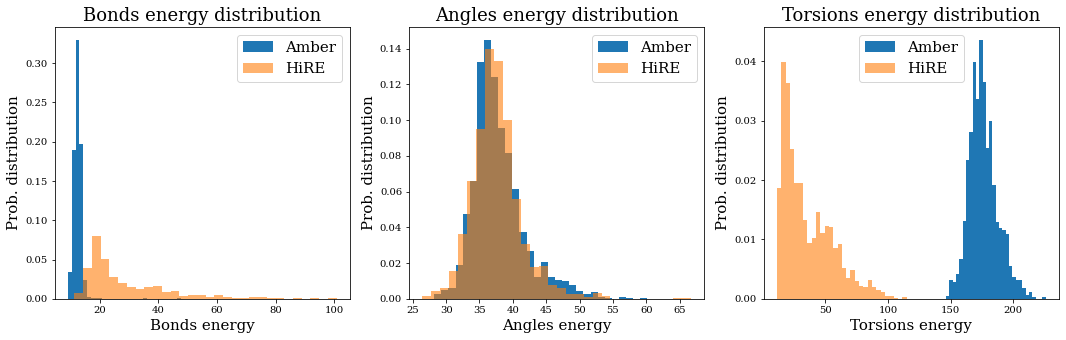

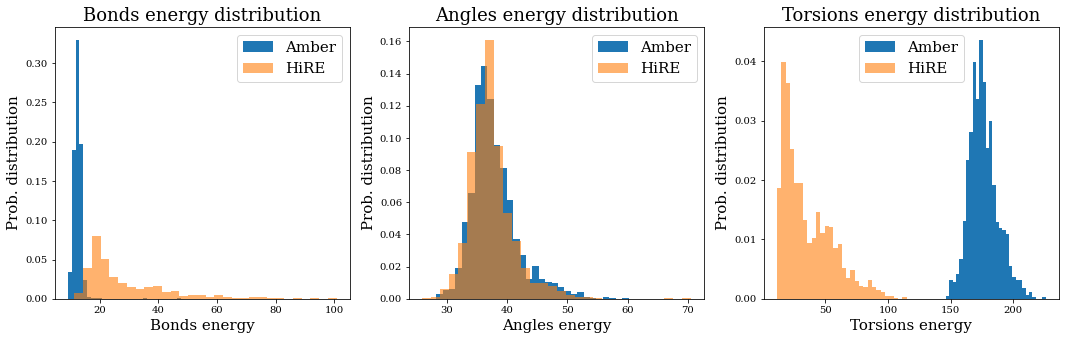

In [5]:
dataset = RNASeqDataset()
model = LocalEnergy()
model.load_state_dict((torch.load('../results/NewResults/AnglesResults/final_big_purines_new.pth')))
print(model.state_dict())

model2 = LocalEnergyOpt()
model2.load_state_dict((torch.load('../results/NewResults/AnglesResults/final_big_purines.pth')))

# top_pars = pickle.load(open('../data/CSV_minimized/top_par.p', 'rb'))
# dat_pars = pickle.load(open('../data/CSV_minimized/dat_par.p', 'rb'))
# model2 = Model(top_pars=top_pars, dat_pars=dat_pars)
# print(model2.state_dict())
compare_energies(dataset,model,plot=True)
compare_energies(dataset,model2,plot=True)

# print(model(dataset[0]))
# print(model2(dataset[0]))  

In [5]:
model = Model()
model.load_state_dict((torch.load('../results/b4_iv_e3/100ep.pth')))

<All keys matched successfully>

In [12]:
model.load_state_dict((torch.load('../results/b4_iv_e3/100ep.pth')))
for i in range(100):
    print(model(dataset[i]))
    
model.load_state_dict((torch.load('../results/initial_values.pth')))
for i in range(100):
    print(model(dataset[i]))


tensor([[  8.2507,  33.0371, 181.3796]], grad_fn=<CopySlices>)
tensor([[ 15.0449,  30.6732, 170.8558]], grad_fn=<CopySlices>)
tensor([[ 17.2488,  49.3172, 191.9861]], grad_fn=<CopySlices>)
tensor([[ 13.9290,  22.7425, 167.2491]], grad_fn=<CopySlices>)
tensor([[ 12.0737,  27.4622, 173.4117]], grad_fn=<CopySlices>)
tensor([[ 11.0709,  25.8208, 167.0111]], grad_fn=<CopySlices>)
tensor([[ 13.7820,  23.3407, 162.6886]], grad_fn=<CopySlices>)
tensor([[ 10.7764,  35.5069, 168.3970]], grad_fn=<CopySlices>)
tensor([[ 11.0843,  40.2517, 182.9267]], grad_fn=<CopySlices>)
tensor([[ 13.0721,  34.7752, 175.1721]], grad_fn=<CopySlices>)
tensor([[ 12.2873,  38.1416, 180.2304]], grad_fn=<CopySlices>)
tensor([[ 15.7071,  43.4253, 176.9821]], grad_fn=<CopySlices>)
tensor([[ 13.7855,  35.6606, 198.3784]], grad_fn=<CopySlices>)
tensor([[ 10.5355,  28.6900, 172.6891]], grad_fn=<CopySlices>)
tensor([[ 11.3272,  34.3189, 187.1770]], grad_fn=<CopySlices>)
tensor([[ 12.3565,  52.4199, 183.3960]], grad_fn=<CopyS

tensor([[22.8387,  9.6913,  5.0170]], grad_fn=<CopySlices>)
tensor([[40.5540, 82.2349, 17.4145]], grad_fn=<CopySlices>)
tensor([[ 36.8460, 144.3650,  37.6291]], grad_fn=<CopySlices>)
tensor([[21.1735, 45.4906, 36.4722]], grad_fn=<CopySlices>)
tensor([[ 45.3871, 114.4203,  27.4287]], grad_fn=<CopySlices>)
tensor([[19.5377, 39.1764, 23.7102]], grad_fn=<CopySlices>)
tensor([[23.4478, 83.0347, 15.4845]], grad_fn=<CopySlices>)
tensor([[18.6695, 24.2839, 13.0080]], grad_fn=<CopySlices>)
tensor([[ 37.2684, 138.3392,  42.2891]], grad_fn=<CopySlices>)
tensor([[32.8680, 86.6840, 20.2000]], grad_fn=<CopySlices>)
tensor([[ 54.3016, 172.5867,  21.8752]], grad_fn=<CopySlices>)
tensor([[23.4367,  8.9358,  4.7419]], grad_fn=<CopySlices>)
tensor([[13.6064,  9.8377,  6.7127]], grad_fn=<CopySlices>)
tensor([[ 37.7202, 227.5473,  41.4556]], grad_fn=<CopySlices>)
tensor([[19.8151,  8.9257,  4.8415]], grad_fn=<CopySlices>)
tensor([[25.6670, 84.0522, 44.4927]], grad_fn=<CopySlices>)
tensor([[ 21.1535, 121.89